# Feature Selection

In [2]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### Stability Check

In [3]:
boston = load_boston()

b_X = boston['data']
b_Y = boston['target']
b_names = boston['feature_names']

rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(b_X,b_Y)

RandomizedLasso(alpha=0.025, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [4]:
print "Features seleted using LASSO:"
print sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), b_names), reverse=True)

Features seleted using LASSO:
[(1.0, 'RM'), (1.0, 'PTRATIO'), (1.0, 'LSTAT'), (0.595, 'B'), (0.58, 'CHAS'), (0.385, 'TAX'), (0.37, 'CRIM'), (0.235, 'DIS'), (0.23, 'NOX'), (0.15, 'INDUS'), (0.06, 'ZN'), (0.03, 'RAD'), (0.0, 'AGE')]


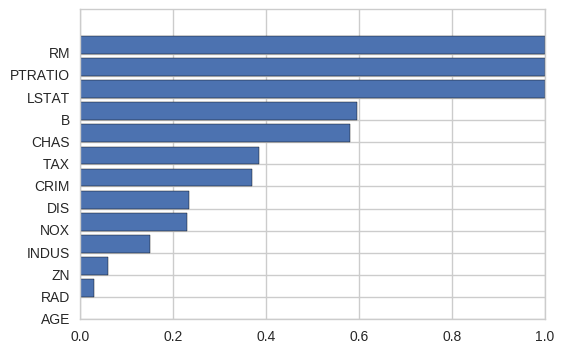

In [6]:
rl = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), b_names), reverse=False)
x = pd.DataFrame(rl)
plt.barh(range(x.shape[0]),x.iloc[:,0])
plt.yticks(range(x.shape[0]),x.iloc[:,1]);

# Using Tree based model to select the features

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
rf = RandomForestRegressor()
rf.fit(b_X, b_Y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), b_names), 
             reverse=True)

Features sorted by their score:
[(0.5067, 'RM'), (0.2994, 'LSTAT'), (0.0593, 'DIS'), (0.0405, 'CRIM'), (0.0222, 'PTRATIO'), (0.0178, 'TAX'), (0.0169, 'NOX'), (0.0163, 'AGE'), (0.0078, 'INDUS'), (0.0078, 'B'), (0.0038, 'RAD'), (0.0012, 'ZN'), (0.0002, 'CHAS')]


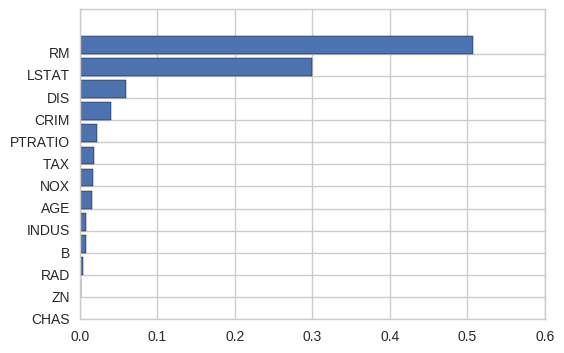

In [9]:
rfr = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), b_names), reverse=False)
x = pd.DataFrame(rfr)
plt.barh(range(x.shape[0]),x.iloc[:,0])
plt.yticks(range(x.shape[0]),x.iloc[:,1]);

# Recursive feature extraction (RFE) using Linear model

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [11]:
lr = LinearRegression()

rfe = RFE(lr, n_features_to_select=1)
rfe.fit(b_X,b_Y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=1, step=1, verbose=0)

In [12]:
print "Features sorted by their rank:"
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), b_names))   

Features sorted by their rank:
[(1.0, 'NOX'), (2.0, 'RM'), (3.0, 'CHAS'), (4.0, 'PTRATIO'), (5.0, 'DIS'), (6.0, 'LSTAT'), (7.0, 'RAD'), (8.0, 'CRIM'), (9.0, 'INDUS'), (10.0, 'ZN'), (11.0, 'TAX'), (12.0, 'B'), (13.0, 'AGE')]


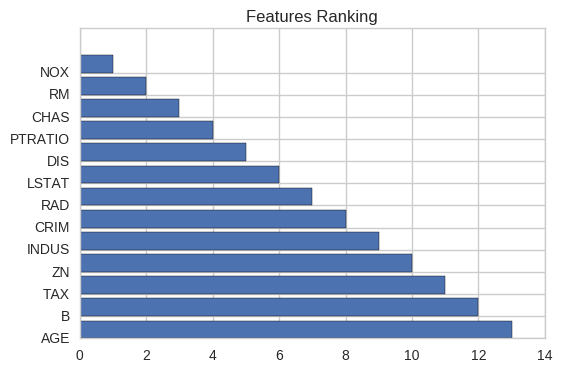

In [14]:
rfelr = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), b_names), reverse=True)
x = pd.DataFrame(rfelr)
plt.barh(range(x.shape[0]),x.iloc[:,0])
plt.title('Features Ranking')
plt.yticks(range(x.shape[0]),x.iloc[:,1]);

# Putting all side by side 

In [15]:
from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#from minepy import MINE

np.random.seed(0)
 
size = 750
X = np.random.uniform(0, 1, (size, 14))
X.shape

(750, 14)

#### Creating dataset for Linear regression(Friedamn regression problem)

In [16]:
#"Friedamn #1” regression problem
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))
#Add 3 additional correlated variables (correlated with X1-X3)
X[:,10:] = X[:,:4] + np.random.normal(0, .025, (size,4))

In [17]:
names = ["x%s" % i for i in range(1,15)]
 
ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [18]:
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
 
 
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
 
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)
 
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
 
 
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)


#mine = MINE()
#mic_scores = []
#for i in range(X.shape[1]):
#    mine.compute_score(X[:,i], Y)
#    m = mine.mic()
#    mic_scores.append(m)
 
#ranks["MIC"] = rank_to_dict(mic_scores, names) 

In [23]:
import pandas as pd
import numpy as np

table = pd.DataFrame(ranks)
table['MEAN'] = [np.mean(table.iloc[i,:]) for i in range(table.shape[0])]
table.sort_values(['MEAN'], ascending=False)

,Corr.,Lasso,Linear reg,RF,RFE,Ridge,Stability,MEAN
x4,1.00,1.00,0.57,0.56,1.00,1.00,1.00,0.875714
x1,0.30,0.79,1.00,0.54,1.00,0.77,0.77,0.738571
x2,0.44,0.83,0.56,0.67,1.00,0.75,0.72,0.710000
x14,0.99,0.16,0.00,1.00,0.22,0.95,0.62,0.562857
x5,0.10,0.51,0.27,0.28,0.78,0.88,0.55,0.481429
x11,0.29,0.00,0.60,0.40,1.00,0.59,0.37,0.464286
x12,0.44,0.00,0.14,0.34,0.67,0.68,0.46,0.390000
x3,0.00,0.00,0.50,0.11,1.00,0.05,0.00,0.237143
x13,0.00,0.00,0.48,0.08,0.89,0.02,0.00,0.210000
x8,0.02,0.00,0.03,0.01,0.56,0.09,0.00,0.101429


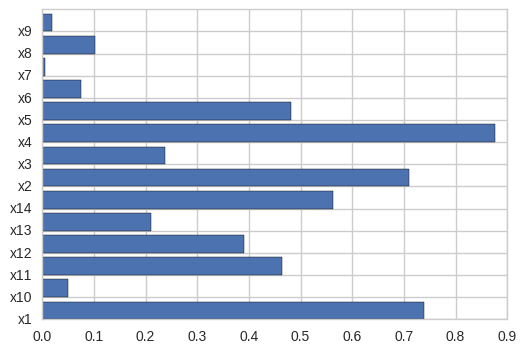

In [20]:
plt.barh(range(table.shape[0]),table.iloc[:,7])
plt.yticks(range(table.shape[0]),table.index);